In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import jit
import scipy as sps

Реализуем класс CubikSpline. При создании объекта класса в конструктор будем передавать ему узлы сетки и значения в них, после чего вычислять коэффициенты многочленов $S_i = a_i + b_i(x - x_{i-1}) + c_i(x - x_{i-1})^2 + d_i(x - x_{i-1})^3$ на соответсвующих отрезках $[x_{i-1}, x_i]$
\par Вычисления брались отсюда -- https://ru.wikipedia.org/wiki/Кубический_сплайн

In [2]:
class CubikSpline:
    
    def __init__(self, grid, f):
        self.grid = grid
        self.f = f
        self.b = None
        self.c = None
        self.d = None
        
        self._find_coeffs()
        
    def find_value(self, x):
        if x < self.grid[0] or x > self.grid[-1]:
            raise AttributeError("x is out of range")
        ind = 1
        while x > self.grid[ind]:
            ind += 1
        t = (x - self.grid[ind - 1])
        return self._find_poly_value(t, ind - 1)
    
        
    def _find_poly_value(self, x, i):
        return self.f[i] + self.b[i] * x + self.c[i] * x**2 + self.d[i] * x**3
    
    def _find_coeffs(self):
        h = np.diff(self.grid)
        df = np.diff(self.f) / h
        
        f = 3 * np.diff(df)
        f = np.insert(f, 0, 0)
        f = np.append(f, 0)
        
        a = h.copy()
        a[-1] = 0
      
        b = 2 * (h[:-1] + h[1:])
        b = np.insert(b, 0, 1)
        b = np.append(b, 1)
        
        c = h.copy()
        c[0] = 0
        self.c = self._solve_tridioganal(a, b, c, f)
        self.d = np.diff(self.c) / (3 * h)
        self.b = df - h / 3 * (2 *self.c[:-1] + self.c[1:])
        
    
    def _solve_tridioganal(self, arr_a, arr_b, arr_c, f):
        '''
        Solve Qx = m
            || b1 c1  0  0 ...  0 ||
            || a2 b2 c2  0 ...  0 ||
        Q = ||       ...          ||
            ||  0  0  0 ... an bn ||

        '''
        
        alphas = np.zeros(len(arr_b) - 1)
        bettas = np.zeros(len(arr_b) - 1)
        
        alphas[0] = - arr_c[0] / arr_b[0]
        alphas[0] = f[0] / arr_b[0]
        
        for ind in range(1, len(arr_b) - 1):
            alphas[ind] = - arr_c[ind] / (arr_a[ind-1] * alphas[ind-1] + arr_b[ind])
            bettas[ind] = (f[ind] - arr_a[ind-1] * bettas[ind-1]) / (arr_a[ind-1] * alphas[ind-1] + arr_b[ind])
        
        x = np.zeros(len(arr_b))
        x[-1] = (f[-1] - arr_a[-1] * bettas[-1]) / (arr_b[-1] + arr_a[-1] * alphas[-1])
        

        for ind in range(len(arr_b) - 2, -1, -1):
            x[ind] = alphas[ind] * x[ind + 1] + bettas[ind]
    
        return x
    

Сделаем функцию, которая будет рисовать график и вычислять непрерывную норму для заданной функции и сетки:

In [3]:
def generate_plot_with_calc(function, grid, num_points):
    values = np.array([function(point) for point in grid])
    kubik_spline = CubikSpline(grid, values)
    
    points = np.linspace(grid[0], grid[-1], num_points)
    
    real_vals = np.array([function(point) for point in points])
    spline_vals = np.array([kubik_spline.find_value(point) for point in points])
    
    marked_points = np.array([kubik_spline.find_value(point) for point in grid])
    
    print('Непрерывная норма разности функции и сплайна: ',np.abs(real_vals - spline_vals).max())
    
    plt.figure(figsize=(16, 9))
    plt.plot(points, real_vals, label='график функции')
    plt.plot(points, spline_vals, label='график сплайна')
    plt.scatter(grid, marked_points, label='значения в точках сетки')
    plt.legend()
    plt.show()
    
    

 Посмотрим, как работает кубический сплайн на функции косинуса и равномерной сетке:

Непрерывная норма разности функции и сплайна:  0.022802107738134625


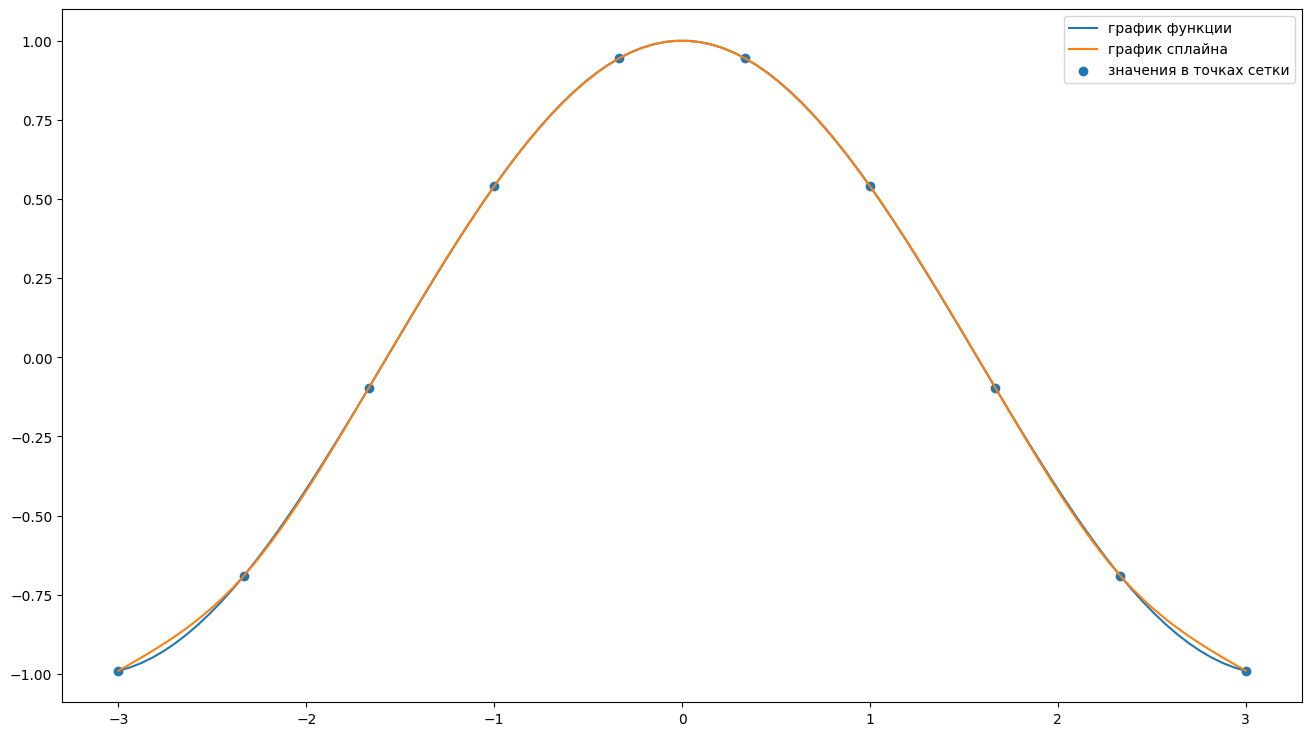

In [4]:
generate_plot_with_calc( np.cos, np.linspace(-3, 3, 10), 100)

Как видим, результат получился достаточно хорошим. Теперь возьмем менее гладкую функцию, например 

$$
f(x) = \frac{1}{19x^2 + 2}
$$

Непрерывная норма разности функции и сплайна:  0.21490137834918


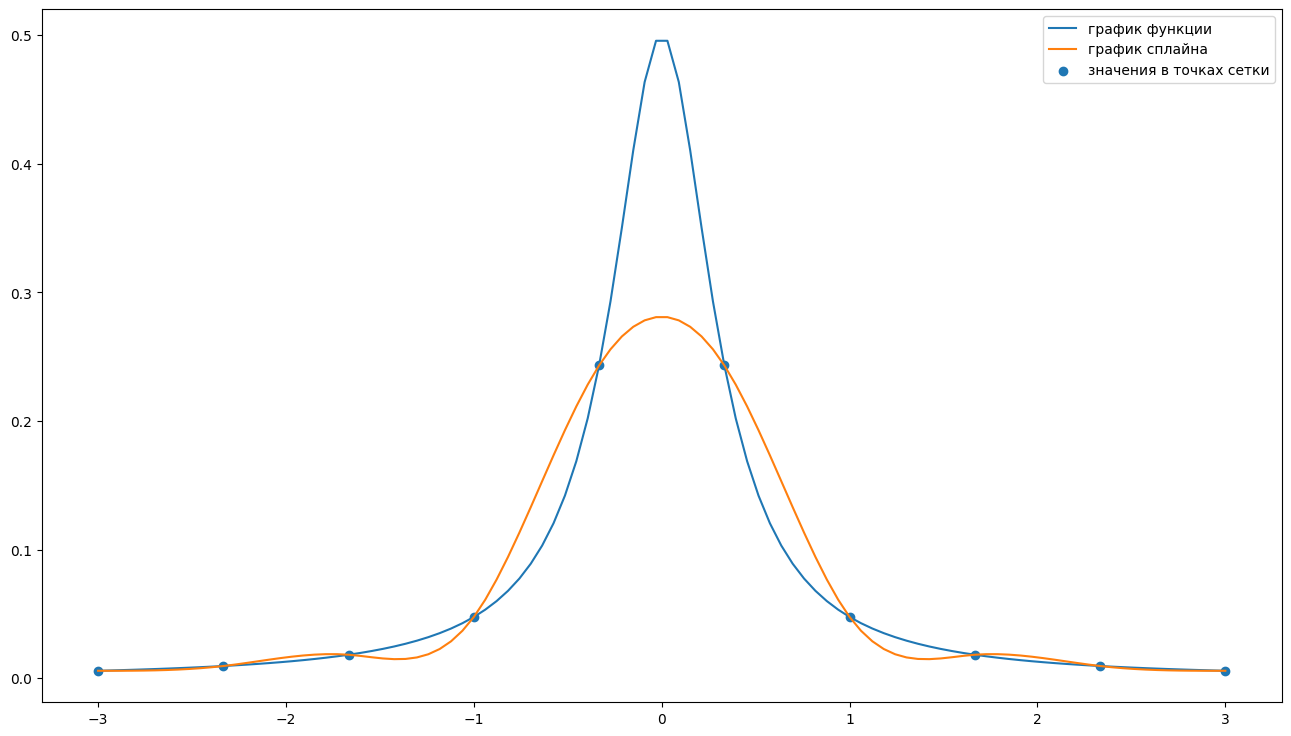

In [5]:
generate_plot_with_calc(lambda x: 1 / (19 * x**2 + 2), np.linspace(-3, 3, 10), 100)

Как видим, приближение получилось не очень. Попробуем исправить неравномерной сеткой:

Непрерывная норма разности функции и сплайна:  0.07713562803745794


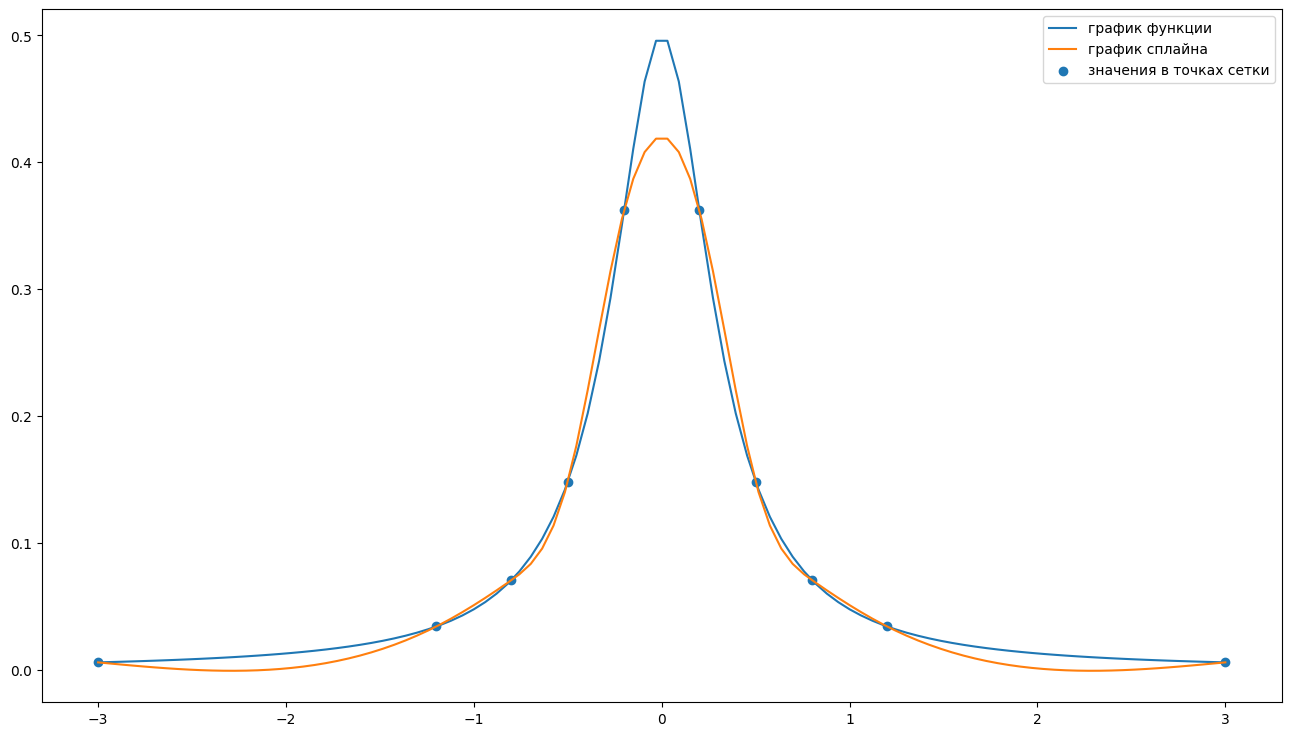

In [6]:
grid = [-3, -1.2, -0.8, -0.5, -0.2, 0.2, 0.5, 0.8, 1.2 ,3]
generate_plot_with_calc( lambda x: 1 / (19 * x ** 2 + 2),grid, 100)

Действительно, неравномерная сетка помогла. Попробуем также увеличить число точек:

Непрерывная норма разности функции и сплайна:  0.0009404188486588638


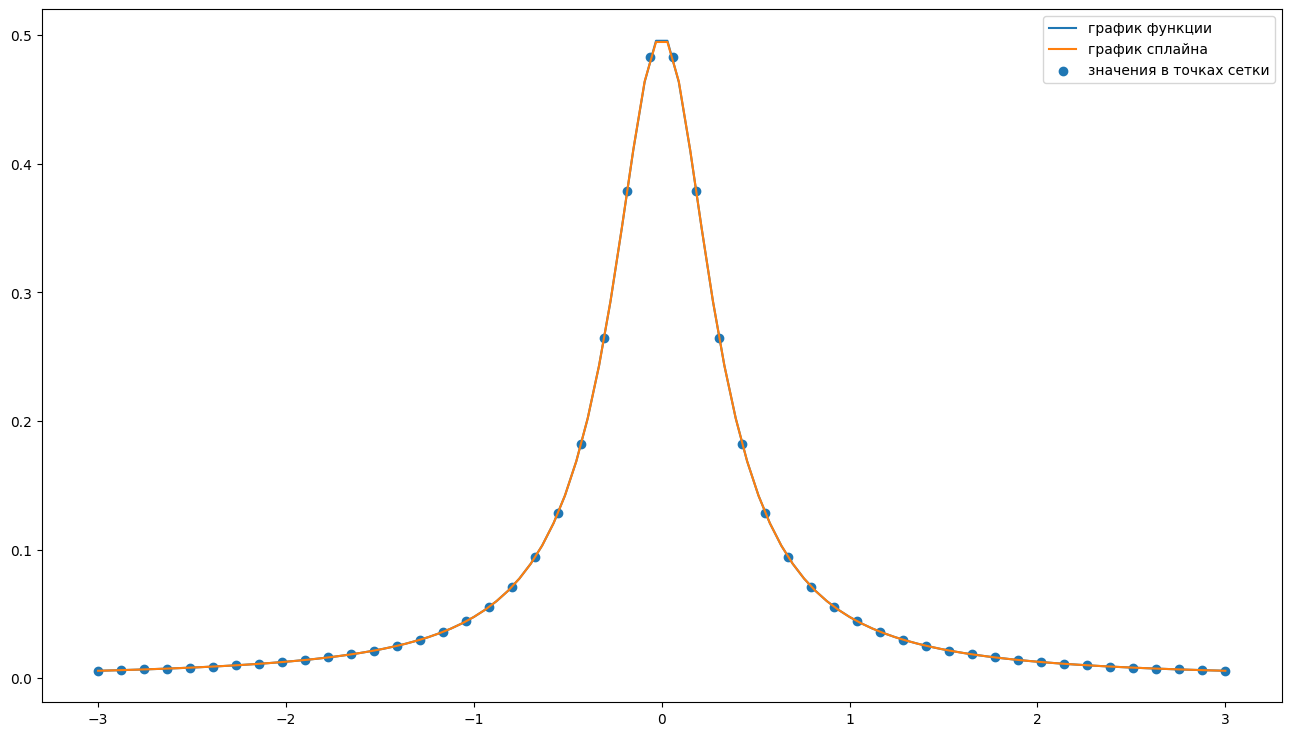

In [7]:
generate_plot_with_calc( lambda x: 1 / (19 * x ** 2 + 2),np.linspace(-3,3, 50), 100)

Как видим, и в этом случае точность улучшилась.